# Genshin Impact Rerun Analysis

This notebook analyzes the relationship between character rerun intervals and wish activity (popularity) using data cleaned from `wish_stats.txt`.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set style
plt.style.use('seaborn-v0_8') # Or 'ggplot' if seaborn not available

## 1. Load Data
Load the cleaned CSV file.

In [3]:
df = pd.read_csv("cleaned_wish_data.csv")
df.head()

,Version,Phase,Character,WishCount,DaysSinceLaunch,MajorVersion,RerunInterval,RerunCount
0,1.3,B,Hu Tao,19125,147,1,NaN,0
1,1.4,A,Venti,34416,168,1,NaN,0
2,1.4,B,Tartaglia,47426,189,1,NaN,0
3,1.5,A,Zhongli,101479,210,1,NaN,0
4,1.5,B,Eula,106000,231,1,NaN,0


## 2. Feature Engineering
Calculate Relative Popularity (Z-Score) per Major Version.

In [4]:
# Group by Major Version and calculate Z-score of WishCount
mv_stats = df.groupby('MajorVersion')['WishCount'].agg(['mean', 'std']).reset_index()
df = df.merge(mv_stats, on='MajorVersion', suffixes=('', '_mv'))
df['ZScore'] = (df['WishCount'] - df['mean']) / df['std']

Calculate **Previous Banner Popularity** for correlating with *wait time*.

In [5]:
df.sort_values(['Character', 'DaysSinceLaunch'], inplace=True)
df['PrevZScore'] = df.groupby('Character')['ZScore'].shift(1)

# Filter for reruns (rows where RerunInterval is present)
reruns = df.dropna(subset=['RerunInterval']).copy()
reruns['RerunInterval'] = reruns['RerunInterval'].astype(float)

## 3. Visualization

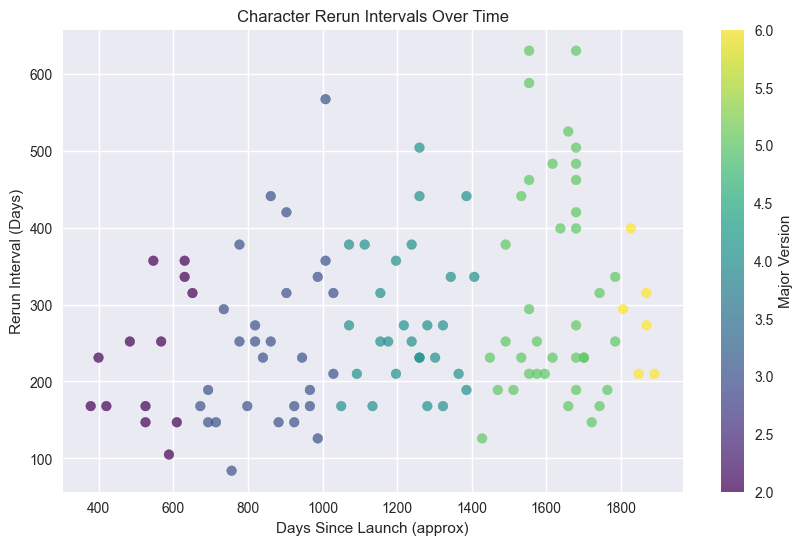

In [6]:
# 3.1 Rerun Interval Trend
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reruns['DaysSinceLaunch'], reruns['RerunInterval'], 
            c=reruns['MajorVersion'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Major Version')
plt.title('Character Rerun Intervals Over Time')
plt.xlabel('Days Since Launch (approx)')
plt.ylabel('Rerun Interval (Days)')
plt.show()

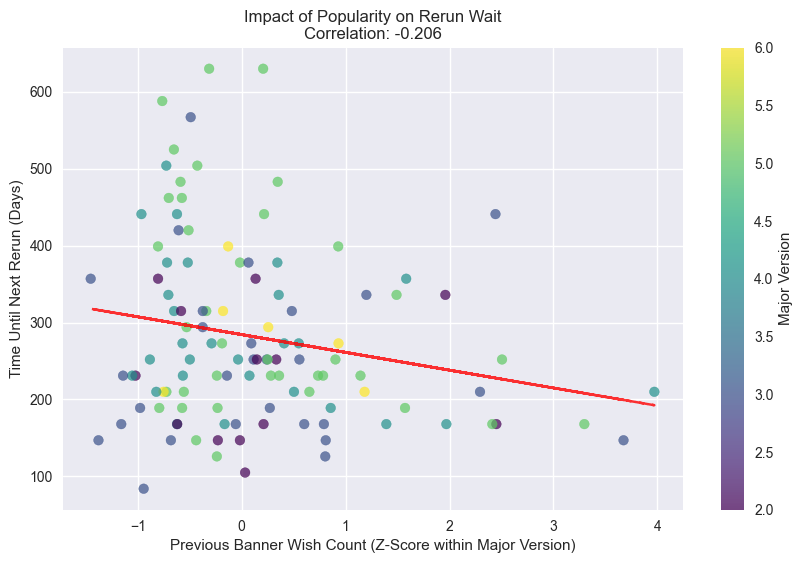

In [7]:
# 3.2 Correlation: Previous Popularity vs Wait Time
plt.figure(figsize=(10, 6))
valid_corr = reruns.dropna(subset=['PrevZScore'])

scatter = plt.scatter(valid_corr['PrevZScore'], valid_corr['RerunInterval'], 
            c=valid_corr['MajorVersion'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Major Version')

# Trend line
z = np.polyfit(valid_corr['PrevZScore'], valid_corr['RerunInterval'], 1)
p = np.poly1d(z)
plt.plot(valid_corr['PrevZScore'], p(valid_corr['PrevZScore']), "r--", alpha=0.8)

corr_val = valid_corr['PrevZScore'].corr(valid_corr['RerunInterval'])
plt.title(f'Impact of Popularity on Rerun Wait\nCorrelation: {corr_val:.3f}')
plt.xlabel('Previous Banner Wish Count (Z-Score within Major Version)')
plt.ylabel('Time Until Next Rerun (Days)')
plt.show()

<Figure size 1000x600 with 0 Axes>

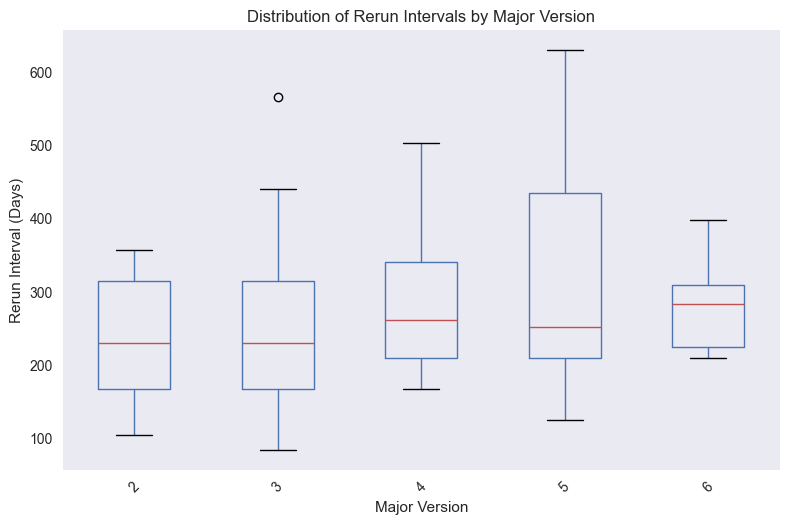

In [8]:
# 3.3 Distribution by Version
plt.figure(figsize=(10, 6))
reruns.boxplot(column='RerunInterval', by='MajorVersion', grid=False, rot=45)
plt.title('Distribution of Rerun Intervals by Major Version')
plt.suptitle('')
plt.ylabel('Rerun Interval (Days)')
plt.xlabel('Major Version')
plt.tight_layout()
plt.show()

## 4. Statistics Summary

In [9]:
print("Correlation (Prev Popularity vs Interval):")
print(valid_corr[['PrevZScore', 'RerunInterval']].corr())

print("\nAverage Rerun Interval by Major Version:")
print(reruns.groupby('MajorVersion')['RerunInterval'].mean())

Correlation (Prev Popularity vs Interval):
               PrevZScore  RerunInterval
PrevZScore       1.000000      -0.206227
RerunInterval   -0.206227       1.000000

Average Rerun Interval by Major Version:
MajorVersion
2    231.000000
3    249.000000
4    282.000000
5    319.973684
6    283.500000
Name: RerunInterval, dtype: float64
